In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from ast import literal_eval
from shapely.geometry import LineString, Point
import networkx as nx
import folium
import time
import warnings
import pickle
import sys
warnings.filterwarnings('ignore')
print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
# import modules
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork
from dijkstra_path_prediction import DijkstraPathPrediction

In [3]:
# Load a model from pickle
datasize = 'full'
location = 'tromso'
model_date = '202204'
train_date = '202205'
test_date = '202206'
DP_tol = 10
min_samples = 12

model_name = model_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+datasize+'_UTM'
model_path = '../../models/networks/best_networks/' + model_name + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 12,
 'clustering_min_cluster_size': 12,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 1.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-02, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 1.e-02, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 0.e+00, 5.e-04]]),
 'graph_generation_max_distance': 10,
 'graph_generation_max_angle': 45}

In [4]:
# Load training data from file
filename = model_name+'_'+train_date+'training_data.csv'
training_data = pd.read_csv('../../data/train_test/'+filename)
training_data['path'] = training_data['path'].apply(literal_eval)
training_data = gpd.GeoDataFrame(training_data, geometry=gpd.GeoSeries.from_wkt(training_data['geometry']), crs='32632')

In [5]:
# Load test data from file
filename = model_name+'_'+test_date+'training_data.csv'
test_data = pd.read_csv('../../data/train_test/'+filename)
test_data['path'] = test_data['path'].apply(literal_eval)
test_data = gpd.GeoDataFrame(test_data, geometry=gpd.GeoSeries.from_wkt(test_data['geometry']), crs='32632')

# Load respective trajectories for evaluation
traj_file = test_date+'_points_'+location+'_cleaned_meta_full_dualSplit_2'
filename = '../../data/processed/' + traj_file + '.parquet'
traj_gdf = gpd.read_parquet(filename)
crs = 32632  # Coordinate reference system
traj_gdf.to_crs(crs, inplace=True)  # Transformation
test_trajectories = mpd.TrajectoryCollection(traj_gdf, traj_id_col='mmsi', obj_id_col='mmsi')

In [10]:
training_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Unnamed: 0        1472 non-null   int64   
 1   mmsi              1472 non-null   object  
 2   SSPD              1472 non-null   float64 
 3   distances         1472 non-null   object  
 4   fraction_covered  1472 non-null   float64 
 5   message           1472 non-null   object  
 6   path              1472 non-null   object  
 7   path_linestring   1472 non-null   object  
 8   lengde            1472 non-null   int64   
 9   bredde            1075 non-null   float64 
 10  dypgaaende        975 non-null    float64 
 11  skipstype         1075 non-null   object  
 12  skipsgruppe       1075 non-null   object  
 13  geometry          1472 non-null   geometry
dtypes: float64(4), geometry(1), int64(2), object(7)
memory usage: 161.1+ KB


In [6]:
# train model
model = DijkstraPathPrediction()
model.train(network.G_pruned, training_data['path'])

Evaluating model on 1564 samples
Progress: 10%...20%...30%...40%...50%...roundtrip 7 7
60%...70%...80%...90%...Done!


Mean SSPD: 384.03m
Median SSPD: 169.75m


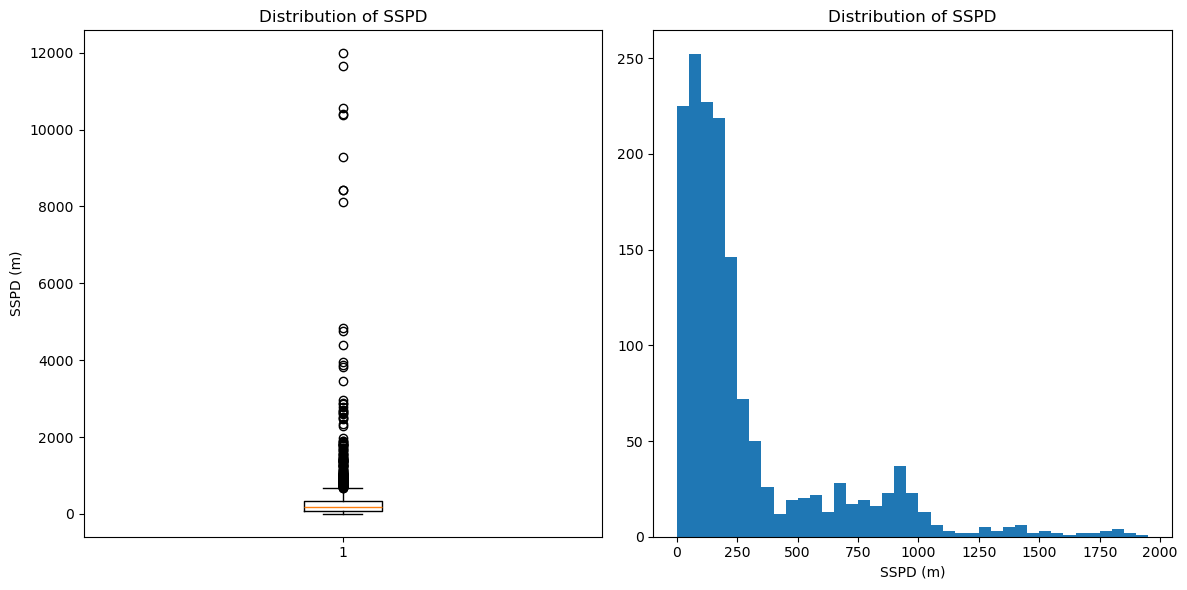

In [7]:
# evaluate model
selection = range(0, len(test_data), 1)
test_paths = test_data.iloc[selection]
eval_results = model.evaluate(test_paths[['mmsi', 'path']], test_trajectories, network, eval_mode='trajectory')

In [9]:
eval_results

,mmsi,true_path,predicted_path,distances,SSPD
0,210055000_0_2022-06-01 09:31:46,"[143, 141, 2, 356, 355, 349, 346, 471, 484, 49...","[143, 142, 141, 2, 353, 356, 355, 354, 349, 34...","[102.38048145704865, 111.71808819979071, 117.5...",890.299232
0,210055000_8_2022-06-01 20:12:01,"[529, 527, 516, 515, 514, 502, 371, 503, 508, ...","[529, 528, 527, 516, 515, 514, 502, 503, 501, ...","[10.140162010288114, 5.533079955312265, 1.7690...",88.750064
0,210189000_0_2022-06-24 06:55:42,"[207, 202, 200, 199, 250, 249, 235, 256, 285, ...","[207, 202, 200, 199, 250, 249, 267, 251, 285, ...","[41.40497947011437, 38.613020638855, 30.521691...",211.019839
0,210189000_100_2022-06-30 09:45:31,"[486, 485, 480, 28, 475, 470, 465, 473, 474, 4...","[486, 485, 480, 28, 475, 470, 465, 473, 474, 4...","[7.002395107157489, 6.946466322983776, 6.89110...",84.686736
0,210189000_8_2022-06-25 16:12:16,"[487, 486, 485, 28]","[487, 486, 485, 480, 28]","[15.300550609750253, 15.866289543654108, 19.76...",29.499641
...,...,...,...,...,...
0,314318000_6_2022-06-08 18:01:01,"[382, 381, 385, 384, 380, 357, 362, 367, 388, ...","[382, 381, 385, 383, 378, 373, 386, 411, 422, ...","[18.50939354417534, 33.18590101275766, 46.4250...",743.829758
0,314377000_0_2022-06-12 14:12:15,"[122, 51]","[122, 51]","[519.1602573427891, 527.5770184793723, 531.085...",744.691991
0,314631000_0_2022-06-09 14:42:08,"[207, 202, 200, 199, 250, 249, 267, 256, 334, ...","[207, 202, 200, 199, 250, 249, 267, 251, 285, ...","[64.89404692183558, 60.78725230171955, 57.9654...",900.975430
0,319139200_0_2022-06-10 14:50:38,"[207, 202]","[207, 202]","[58.85519245224754, 59.17261516483973, 61.3616...",53.807657


In [ ]:
# load trajectories

In [ ]:
# plot network and basemap
network.prune_graph(100)
map = network.map_graph(pruned=True, center=[69, 19])  #tromso: center=[69, 19]

# plot prediction and ground truth
selection = [1, 2, 3, 4, 5]
for i in selection:
    mmsi = eval_results['mmsi'].iloc[i]
    predicted_path = eval_results['predicted_path'].iloc[i]
    true_path = eval_results['true_path'].iloc[i]
    true_path_line = geometry_utils.get_geo_df(true_path, network.waypoint_connections)
    predicted_path_line = geometry_utils.get_geo_df(predicted_path, network.waypoint_connections)
    predicted_path_line['SSPD'] = eval_results['SSPD'].iloc[i]
    trajectory = test_trajectories.get_trajectory(mmsi).to_line_gdf()

    map = trajectory[['mmsi', 'geometry', 'skipsgruppe', 'length', 'bredde']].explore(m=map, style_kwds={'weight':3, 'color':'black', 'opacity':1},
                                                                                      name=f'{mmsi} trajectory')
    map = true_path_line.explore(m=map, style_kwds={'weight':3, 'color':'cyan', 'opacity':1},
                               name=f'{mmsi} closest path')
    map = predicted_path_line.explore(m=map, style_kwds={'weight':3, 'color':'yellow', 'opacity':1},
                                   name=f'{mmsi} prediction')
    
folium.LayerControl().add_to(map)
map.save('../../reports/maps/'+model_name+'_predictions.html')